### Image Loading and Training ###
This notebook handles all image loading, such as resizing them to 100x100, creating buffers and batches, and setting autotune. It does not save them as Tensorflow Datasets, but rather, directly trains on the data using TF version 2.8.3. This is to avoid bugs while using the Tensorflow Model Data Augmentation Layers, which occurs in TF version 2.10. However, ver 2.8.3 does not support loading TF Datasets so training has to be done in the same notebook.

Training data only.

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import h5py

import shutil
from keras.models import load_model
from keras import layers
from keras import models
from keras import optimizers

In [3]:
print(tf.__version__)

2.8.3


In [4]:
# set params
batch_size = 32
img_height = 100
img_width = 100

In [5]:
image_count = 86782 # this number should be extracted from xBD_data_processing.ipynb
data_dir = './xBD_Dataset/building_crops/'
list_ds = tf.data.Dataset.list_files((data_dir + '*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [10]:
data_dir = './xBD_Dataset/building_crops/'
damaged_ds = tf.data.Dataset.list_files((data_dir + 'damaged/*'), shuffle=False)
l1 = len(damaged_ds)
print("Total number of available images in class 'damaged' is:", l1)
undamaged_ds = tf.data.Dataset.list_files((data_dir + 'undamaged/*'), shuffle=False)
l2 = len(undamaged_ds)
print("Total number of available images in class 'undamaged' is:", l2)

Total number of available images in class 'damaged' is: 14006
Total number of available images in class 'undamaged' is: 72776


In [141]:
undamaged_ds = undamaged_ds.shuffle(l2, seed = 207).take(l1)
image_count = l1*2
list_ds = undamaged_ds.concatenate(damaged_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
print("Total number of combined images after undersampling majority class is:", len(list_ds))

Total number of combined images after undersampling majority class is: 28012


In [11]:
for f in list_ds.take(100):
    print(f.numpy())

b'.\\xBD_Dataset\\building_crops\\undamaged\\santa-rosa-wildfire-493-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\tuscaloosa-tornado-3223-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\portugal-wildfire-13922-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\portugal-wildfire-1640-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\moore-tornado-16468-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\woolsey-fire-1442-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\socal-fire-12788-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\santa-rosa-wildfire-8852-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\santa-rosa-wildfire-5821-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\santa-rosa-wildfire-17151-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\woolsey-fire-6-undamaged.png'
b'.\\xBD_Dataset\\building_crops\\undamaged\\portugal-wildfire-10792-undamaged.png'
b'.\\xBD_Datase

In [6]:
class_names = np.array(sorted([item for item in os.listdir(data_dir)],reverse=True))
print(class_names)

['undamaged' 'damaged']


In [7]:
# val_size = int(image_count * 0.1)
# test_size = int(image_count * 0.1)

# train_ds = list_ds.skip(val_size + test_size)
# val_ds = list_ds.take(val_size + test_size)

# test_ds = val_ds.take(test_size)
# val_ds = val_ds.skip(test_size)

In [13]:
val_size = int(image_count * 0.1)

train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
# tensorflow tutorial functions for manual creation of datasets
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # (FORMAT = PNG) convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size (WITH PAD)
    

### VERY IMPORTANT: MAKE SURE THIS IS CORRECT
    return tf.image.resize_with_pad(img, 100, 100)
#     return tf.image.resize(img, (150, 150))
### !!!!!



def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [15]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [17]:
test_ds = list_ds.skip(50000).take(100)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = configure_for_performance(test_ds)

In [10]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (150, 150, 3)
Label:  0


In [16]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [65]:
list_ds = configure_for_performance(list_ds.map(process_path, num_parallel_calls=AUTOTUNE))

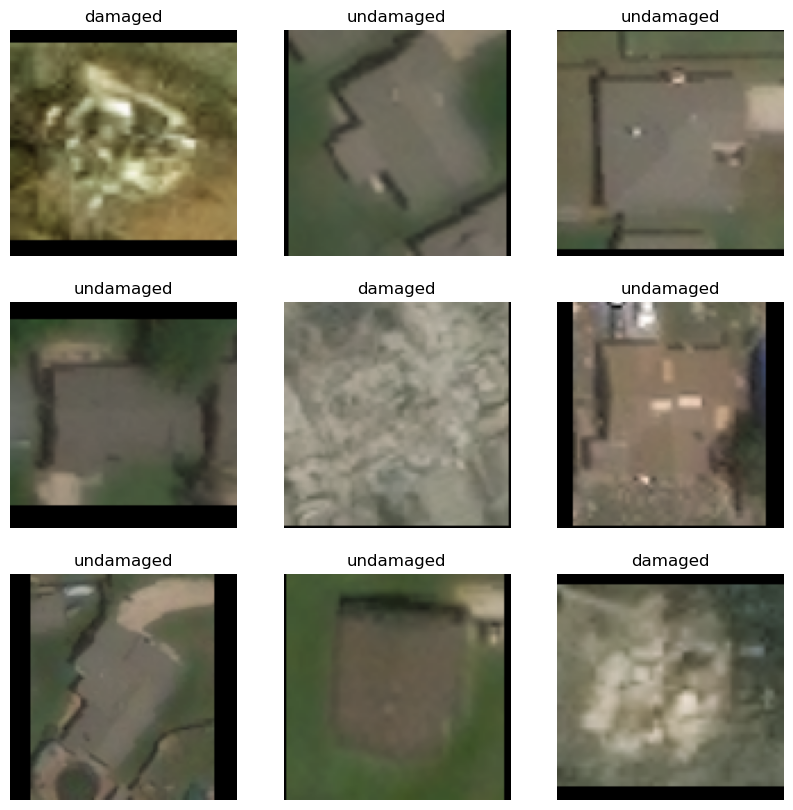

In [26]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

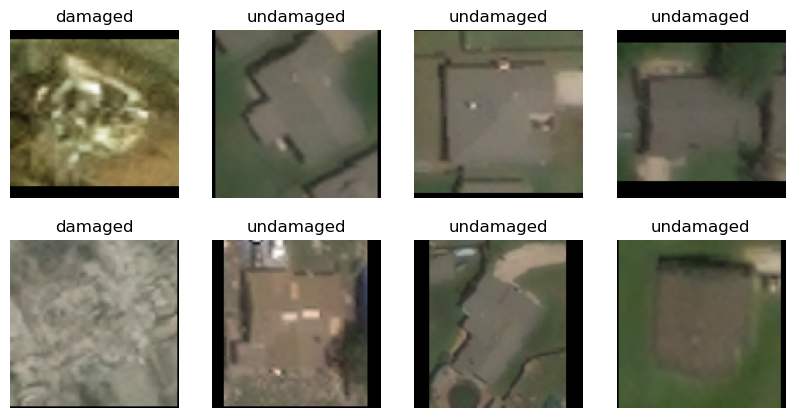

In [27]:
plt.figure(figsize=(10, 5))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [28]:
from keras import optimizers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2,0.2),
])

#try again with Adam optimizer
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape = (100,100,3)))
model.add(data_augmentation)
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                 metrics = [tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])

#fit the model from image generator
history = model.fit(
            train_ds,
            epochs=100,
            validation_data=val_ds)

Epoch 1/100
788/788 [==============================] - 14s 14ms/step - loss: 0.4300 - precision_1: 0.7867 - recall_1: 0.8024 - accuracy: 0.7928 - val_loss: 0.3001 - val_precision_1: 0.8237 - val_recall_1: 0.9817 - val_accuracy: 0.8840
Epoch 2/100
788/788 [==============================] - 8s 10ms/step - loss: 0.2197 - precision_1: 0.9156 - recall_1: 0.9126 - accuracy: 0.9144 - val_loss: 0.1476 - val_precision_1: 0.9662 - val_recall_1: 0.9234 - val_accuracy: 0.9447
Epoch 3/100
788/788 [==============================] - 8s 10ms/step - loss: 0.1885 - precision_1: 0.9312 - recall_1: 0.9240 - accuracy: 0.9280 - val_loss: 0.1318 - val_precision_1: 0.9647 - val_recall_1: 0.9417 - val_accuracy: 0.9529
Epoch 4/100
788/788 [==============================] - 8s 10ms/step - loss: 0.1836 - precision_1: 0.9358 - recall_1: 0.9219 - accuracy: 0.9294 - val_loss: 0.1449 - val_precision_1: 0.9634 - val_recall_1: 0.9241 - val_accuracy: 0.9436
Epoch 5/100
788/788 [==============================] - 8s 10ms/

Epoch 36/100
788/788 [==============================] - 8s 11ms/step - loss: 0.1221 - precision_1: 0.9605 - recall_1: 0.9477 - accuracy: 0.9545 - val_loss: 0.1059 - val_precision_1: 0.9801 - val_recall_1: 0.9353 - val_accuracy: 0.9575
Epoch 37/100
788/788 [==============================] - 8s 10ms/step - loss: 0.1229 - precision_1: 0.9600 - recall_1: 0.9464 - accuracy: 0.9536 - val_loss: 0.1181 - val_precision_1: 0.9858 - val_recall_1: 0.9262 - val_accuracy: 0.9557
Epoch 38/100
788/788 [==============================] - 8s 10ms/step - loss: 0.1174 - precision_1: 0.9613 - recall_1: 0.9491 - accuracy: 0.9555 - val_loss: 0.1031 - val_precision_1: 0.9773 - val_recall_1: 0.9375 - val_accuracy: 0.9572
Epoch 39/100
788/788 [==============================] - 9s 11ms/step - loss: 0.1206 - precision_1: 0.9610 - recall_1: 0.9490 - accuracy: 0.9553 - val_loss: 0.1040 - val_precision_1: 0.9766 - val_recall_1: 0.9382 - val_accuracy: 0.9572
Epoch 40/100
788/788 [==============================] - 8s 1

Epoch 71/100
788/788 [==============================] - 8s 11ms/step - loss: 0.1150 - precision_1: 0.9615 - recall_1: 0.9499 - accuracy: 0.9561 - val_loss: 0.0922 - val_precision_1: 0.9768 - val_recall_1: 0.9480 - val_accuracy: 0.9622
Epoch 72/100
788/788 [==============================] - 9s 11ms/step - loss: 0.1146 - precision_1: 0.9637 - recall_1: 0.9499 - accuracy: 0.9571 - val_loss: 0.0995 - val_precision_1: 0.9830 - val_recall_1: 0.9332 - val_accuracy: 0.9579
Epoch 73/100
788/788 [==============================] - 8s 11ms/step - loss: 0.1159 - precision_1: 0.9620 - recall_1: 0.9511 - accuracy: 0.9568 - val_loss: 0.0903 - val_precision_1: 0.9706 - val_recall_1: 0.9515 - val_accuracy: 0.9607
Epoch 74/100
788/788 [==============================] - 9s 11ms/step - loss: 0.1157 - precision_1: 0.9632 - recall_1: 0.9493 - accuracy: 0.9566 - val_loss: 0.0931 - val_precision_1: 0.9846 - val_recall_1: 0.9410 - val_accuracy: 0.9625
Epoch 75/100
788/788 [==============================] - 8s 1

In [37]:
from keras import optimizers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2,0.2),
])

#try again with Adam optimizer
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape = (100,100,3)))
model.add(data_augmentation)
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(1024,activation = 'relu'))
model.add(layers.Dense(512,activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                 metrics = [tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                  

In [39]:
#fit the model from image generator
history = model.fit(
            train_ds,
            epochs=100,
            validation_data=val_ds)

Epoch 1/100
2441/2441 [==============================] - 60s 24ms/step - loss: 0.2910 - precision: 0.7779 - recall: 0.4180 - accuracy: 0.8870 - val_loss: 0.1768 - val_precision: 0.9381 - val_recall: 0.6408 - val_accuracy: 0.9343
Epoch 2/100
2441/2441 [==============================] - 24s 10ms/step - loss: 0.1748 - precision: 0.8695 - recall: 0.7143 - accuracy: 0.9367 - val_loss: 0.1385 - val_precision: 0.9209 - val_recall: 0.7866 - val_accuracy: 0.9540
Epoch 3/100
2441/2441 [==============================] - 26s 11ms/step - loss: 0.1497 - precision: 0.8949 - recall: 0.7651 - accuracy: 0.9477 - val_loss: 0.1257 - val_precision: 0.9333 - val_recall: 0.7986 - val_accuracy: 0.9577
Epoch 4/100
2441/2441 [==============================] - 25s 10ms/step - loss: 0.1415 - precision: 0.9001 - recall: 0.7836 - accuracy: 0.9511 - val_loss: 0.1149 - val_precision: 0.9287 - val_recall: 0.8254 - val_accuracy: 0.9611
Epoch 5/100
2441/2441 [==============================] - 24s 10ms/step - loss: 0.135

Epoch 37/100
2441/2441 [==============================] - 24s 10ms/step - loss: 0.1125 - precision: 0.9214 - recall: 0.8321 - accuracy: 0.9615 - val_loss: 0.0966 - val_precision: 0.9496 - val_recall: 0.8500 - val_accuracy: 0.9681
Epoch 38/100
2441/2441 [==============================] - 24s 10ms/step - loss: 0.1130 - precision: 0.9235 - recall: 0.8328 - accuracy: 0.9619 - val_loss: 0.0976 - val_precision: 0.9440 - val_recall: 0.8542 - val_accuracy: 0.9678
Epoch 39/100
2441/2441 [==============================] - 24s 10ms/step - loss: 0.1116 - precision: 0.9233 - recall: 0.8358 - accuracy: 0.9623 - val_loss: 0.1138 - val_precision: 0.8845 - val_recall: 0.8951 - val_accuracy: 0.9637
Epoch 40/100
2441/2441 [==============================] - 24s 10ms/step - loss: 0.1129 - precision: 0.9261 - recall: 0.8384 - accuracy: 0.9632 - val_loss: 0.0962 - val_precision: 0.9444 - val_recall: 0.8606 - val_accuracy: 0.9689
Epoch 41/100
2441/2441 [==============================] - 24s 10ms/step - loss: 

Epoch 73/100
2441/2441 [==============================] - 24s 10ms/step - loss: 0.1065 - precision: 0.9273 - recall: 0.8444 - accuracy: 0.9643 - val_loss: 0.0982 - val_precision: 0.9443 - val_recall: 0.8592 - val_accuracy: 0.9687
Epoch 74/100
2441/2441 [==============================] - 24s 10ms/step - loss: 0.1069 - precision: 0.9270 - recall: 0.8459 - accuracy: 0.9644 - val_loss: 0.0913 - val_precision: 0.9382 - val_recall: 0.8761 - val_accuracy: 0.9703
Epoch 75/100
2441/2441 [==============================] - 24s 10ms/step - loss: 0.1075 - precision: 0.9277 - recall: 0.8443 - accuracy: 0.9643 - val_loss: 0.0986 - val_precision: 0.9518 - val_recall: 0.8338 - val_accuracy: 0.9659
Epoch 76/100
2441/2441 [==============================] - 24s 10ms/step - loss: 0.1061 - precision: 0.9276 - recall: 0.8455 - accuracy: 0.9645 - val_loss: 0.0971 - val_precision: 0.9259 - val_recall: 0.8711 - val_accuracy: 0.9675
Epoch 77/100
2441/2441 [==============================] - 24s 10ms/step - loss: 

In [12]:
from keras import optimizers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.2,0.2),
])

#try again with Adam optimizer
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape = (150,150,3)))
model.add(data_augmentation)
model.add(layers.Conv2D(32,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512,activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                 metrics = [tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                  

In [13]:
#fit the model from image generator
history = model.fit(
            train_ds,
            epochs=10,
            validation_data=val_ds)

Epoch 1/10
2441/2441 [==============================] - 75s 29ms/step - loss: 0.2700 - precision: 0.8061 - recall: 0.4649 - accuracy: 0.8956 - val_loss: 0.1305 - val_precision: 0.9514 - val_recall: 0.7579 - val_accuracy: 0.9548
Epoch 2/10
2441/2441 [==============================] - 54s 22ms/step - loss: 0.1654 - precision: 0.8849 - recall: 0.7403 - accuracy: 0.9425 - val_loss: 0.1295 - val_precision: 0.9608 - val_recall: 0.7550 - val_accuracy: 0.9556
Epoch 3/10
2441/2441 [==============================] - 51s 21ms/step - loss: 0.1517 - precision: 0.8953 - recall: 0.7669 - accuracy: 0.9479 - val_loss: 0.1243 - val_precision: 0.9264 - val_recall: 0.8202 - val_accuracy: 0.9606
Epoch 4/10
2441/2441 [==============================] - 46s 19ms/step - loss: 0.1452 - precision: 0.9031 - recall: 0.7784 - accuracy: 0.9507 - val_loss: 0.1154 - val_precision: 0.9403 - val_recall: 0.8016 - val_accuracy: 0.9599
Epoch 5/10
2441/2441 [==============================] - 45s 19ms/step - loss: 0.1403 - p

In [15]:
model.save('cc_model_with_dropout_5.h5')

In [20]:
pred = model.predict(test_ds)

In [22]:
pred>0.5

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [

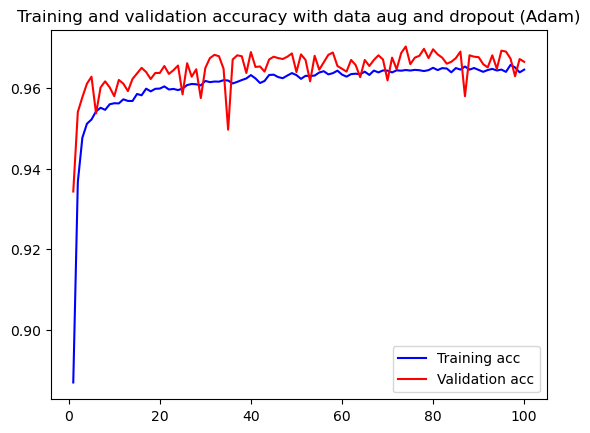

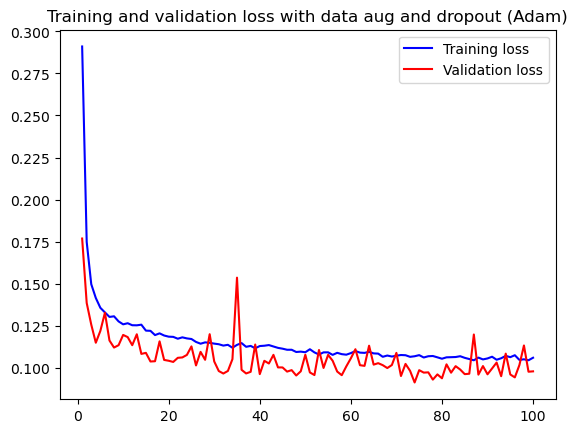

In [50]:
#plot loss and accuracy for detection overfitting
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy with data aug and dropout (Adam)')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss with data aug and dropout (Adam)')
plt.legend()

plt.show()

In [40]:
# model.save('cc_model_with_dropout_4.h5')

In [6]:
from keras.preprocessing import image
# img_path = './xBD_Dataset/building_crops/damaged/joplin-tornado-8996-damaged.png'
img_path = './xBD_Dataset/building_crops/damaged/santa-rosa-wildfire-9226-damaged.png'
# img_path = './xBD_Dataset/building_crops/undamaged/santa-rosa-wildfire-14365-undamaged.png'
# img_path = './xBD_Dataset/building_crops/undamaged/socal-fire-7678-undamaged.png'
# img_path = './xBD_Dataset/building_crops/undamaged/santa-rosa-wildfire-13021-undamaged.png'

img = image.load_img(img_path, target_size = (100,100))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
# img_tensor /= 255.

print(img_tensor.shape)

(1, 100, 100, 3)


In [7]:
# # This cell is for picking an image directly from the test set Dataset

# pick_index = 20

# img_tensor = next(iter(test_ds))[0].numpy()[np.newaxis,pick_index]
# label = next(iter(test_ds))[1].numpy()[pick_index]
# print("Size is ", img_tensor.shape)
# print("Label is ", label)

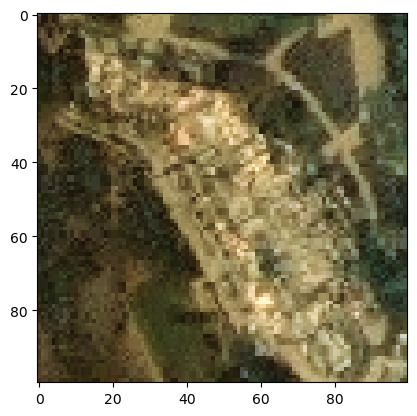

In [8]:
plt.imshow(img_tensor[0]/255.)
plt.show()

In [ ]:
model = tf.keras.models.load_model('cc_model_with_dropout_4.h5')

In [ ]:
from  keras.utils.vis_utils  import plot_model
plot_model(model,show_shapes=True, to_file='cc_model_with_dropout_4.png')

In [50]:
layer_outputs = [layer.output for layer in model.layers[2:]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

In [51]:
activations = activation_model.predict(img_tensor)
print(activations[-1])

[[0.05593026]]


In [42]:
# model.predict(list_ds)

(1, 98, 98, 32)


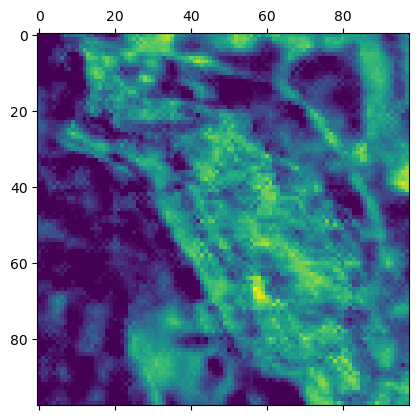

In [43]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0,:,:,2]*255,cmap = 'viridis');

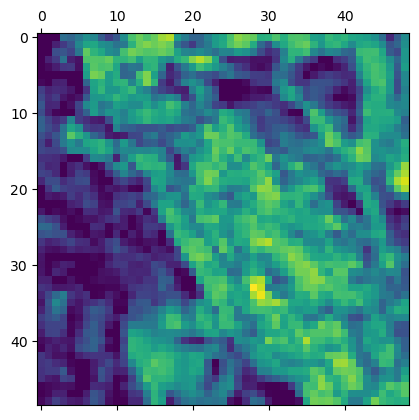

In [44]:
second_layer_activation = activations[1]
plt.matshow(second_layer_activation[0,:,:,2]*255,cmap = 'viridis');

D:\temp\ipykernel_18860\3391148442.py:15: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
D:\temp\ipykernel_18860\3391148442.py:18: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


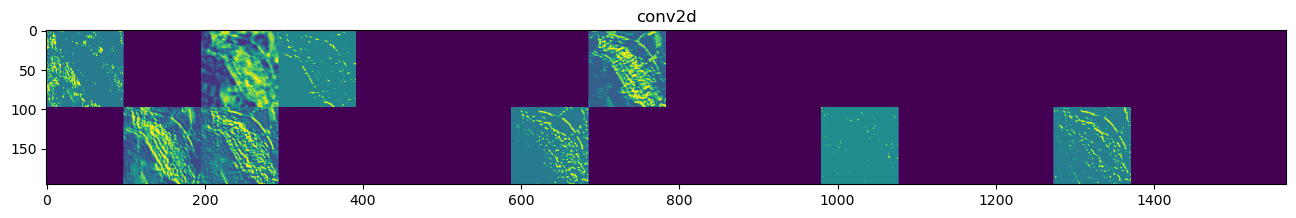

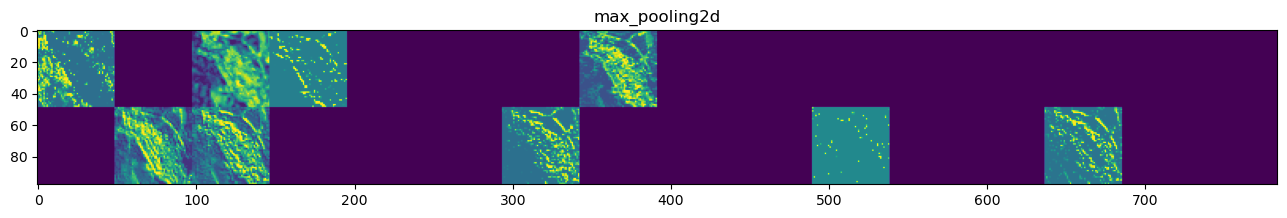

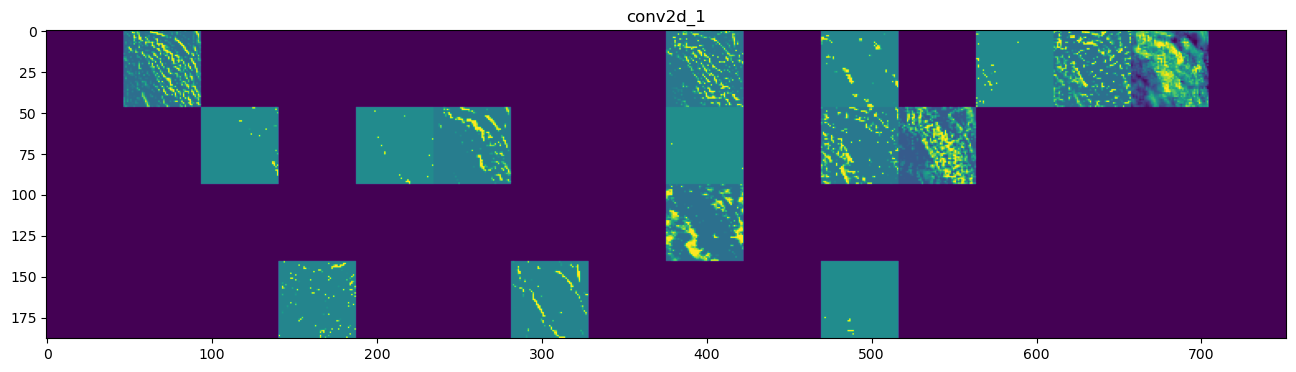

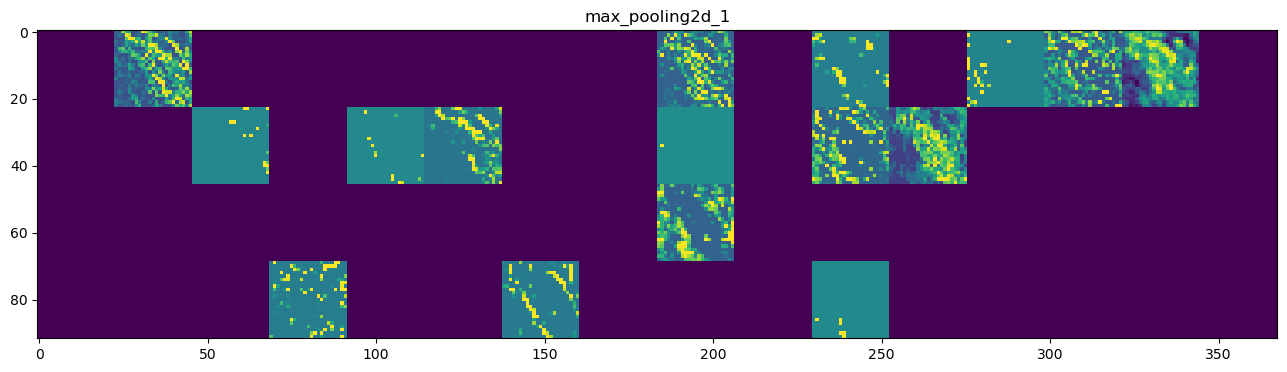

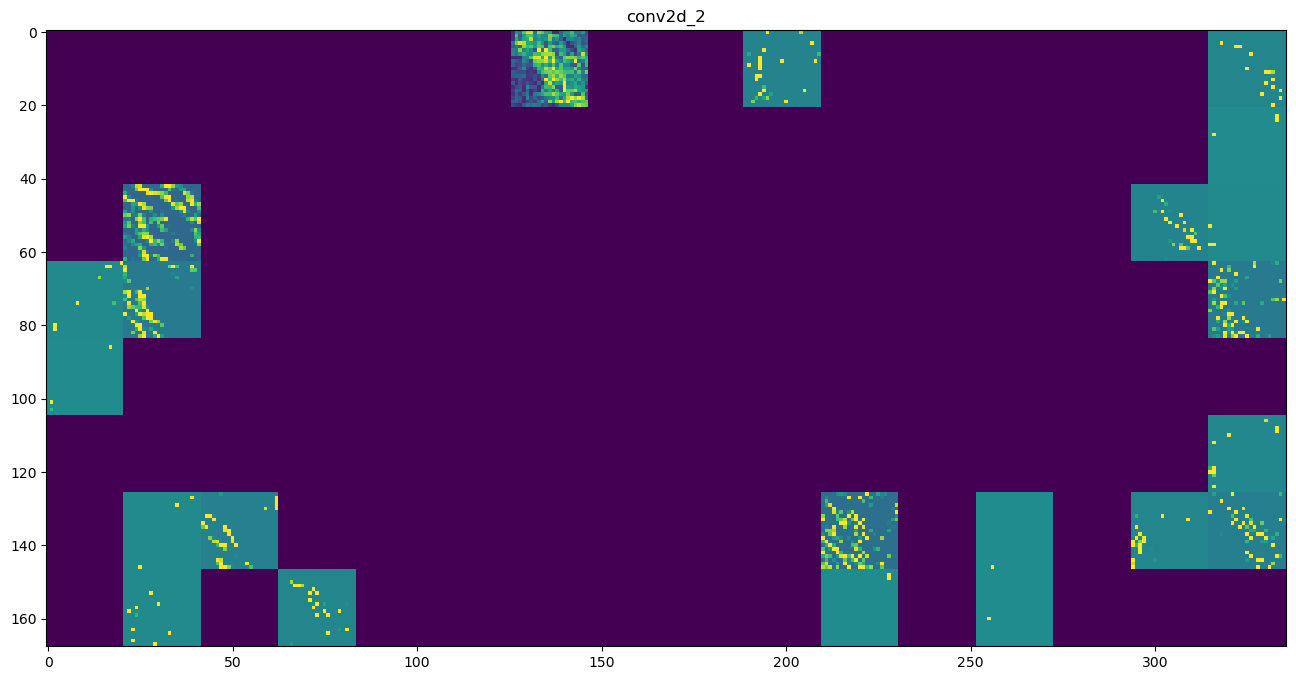

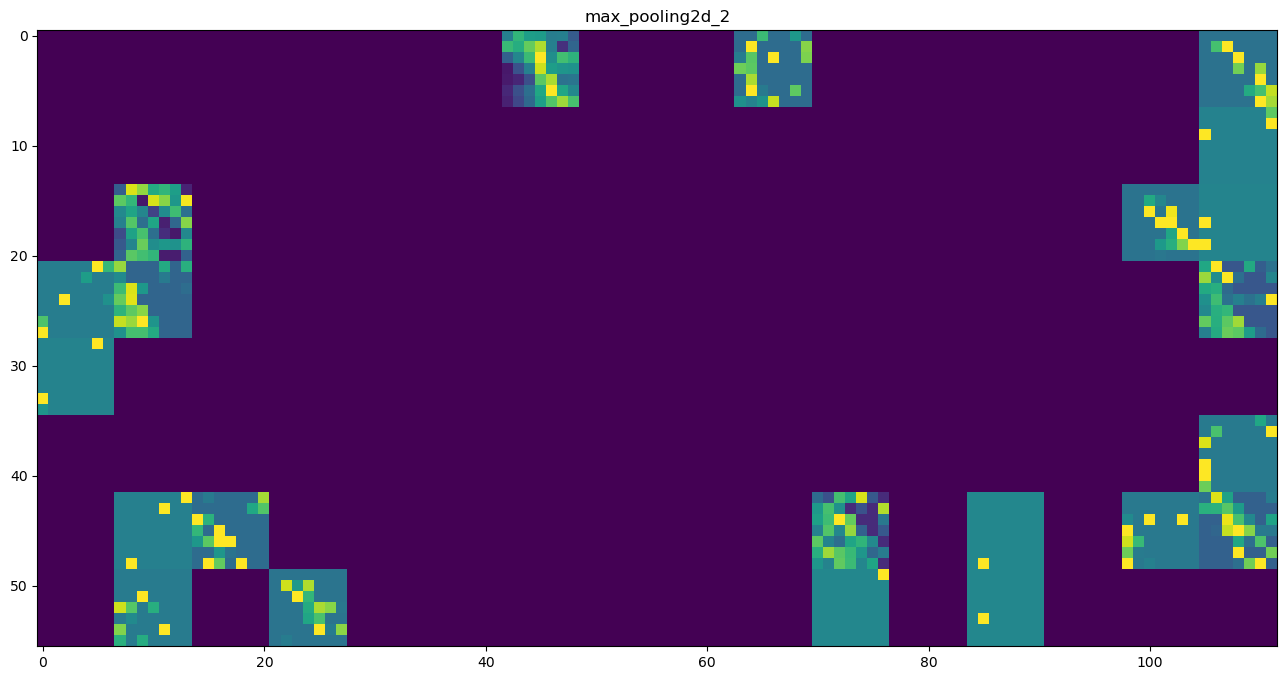

In [45]:
layer_names =[]
for layer in model.layers[2:8]:
    layer_names.append(layer.name)
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features//images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row+row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col*size:(col+1)*size,row*size:(row+1)*size] = channel_image
    scale = 1./size
    plt.figure(figsize=(scale*display_grid.shape[1],
                        scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

In [11]:
model = tf.keras.models.load_model('vgg16_3.h5')

In [17]:
model.evaluate(val_ds)

InvalidArgumentError: Graph execution error:

Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "D:\Anaconda3\envs\tf2.8.3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Anaconda3\envs\tf2.8.3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "D:\Anaconda3\envs\tf2.8.3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "D:\Anaconda3\envs\tf2.8.3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "D:\Anaconda3\envs\tf2.8.3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "D:\temp\ipykernel_11432\1948569052.py", line 1, in <module>
      model.evaluate(val_ds)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 1716, in evaluate
      tmp_logs = self.test_function(iterator)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 1525, in test_function
      return step_function(self, iterator)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 1514, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 1507, in run_step
      outputs = model.test_step(data)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 1474, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\metrics.py", line 1403, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
Detected at node 'assert_greater_equal/Assert/AssertGuard/Assert' defined at (most recent call last):
    File "D:\Anaconda3\envs\tf2.8.3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Anaconda3\envs\tf2.8.3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
      self.io_loop.start()
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "D:\Anaconda3\envs\tf2.8.3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "D:\Anaconda3\envs\tf2.8.3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "D:\Anaconda3\envs\tf2.8.3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "D:\temp\ipykernel_11432\1948569052.py", line 1, in <module>
      model.evaluate(val_ds)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 1716, in evaluate
      tmp_logs = self.test_function(iterator)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 1525, in test_function
      return step_function(self, iterator)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 1514, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 1507, in run_step
      outputs = model.test_step(data)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 1474, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\engine\compile_utils.py", line 459, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\metrics.py", line 178, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\metrics.py", line 1403, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "D:\Anaconda3\envs\tf2.8.3\lib\site-packages\keras\utils\metrics_utils.py", line 602, in update_confusion_matrix_variables
      tf.compat.v1.assert_greater_equal(
Node: 'assert_greater_equal/Assert/AssertGuard/Assert'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_7/dense_15/BiasAdd:0) = ] [[-0.930531561][1.29166484][5.99764299]...] [y (Cast_3/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
	 [[assert_less_equal_1/Assert/AssertGuard/pivot_f/_33/_73]]
  (1) INVALID_ARGUMENT:  assertion failed: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (model_7/dense_15/BiasAdd:0) = ] [[-0.930531561][1.29166484][5.99764299]...] [y (Cast_3/x:0) = ] [0]
	 [[{{node assert_greater_equal/Assert/AssertGuard/Assert}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_2175]